В представленном далее датасете содержатся данные о нескольких сотнях учеников, такие как возраст, пол, обстановка в семье, место жительства и много ещё.
Колонка, которая нас интересует больше всего содержит итоговую оценку за экзамен по математике.
Наши цели:
    1) привести данные в порядок (избавиться от выбросов, ошибок)
    2) определить, какие данные помогут в предсказании итоговой оценки и каким образом

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud_math = pd.read_csv('stud_math.csv')

In [2]:
display(stud_math.head(10))
stud_math.info() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Приведём имена всех колонок к более удобному (для меня) виду

In [3]:
stud_math.rename(columns={'Pstatus': 'pstatus', 'Medu': 'medu', 'Fedu': 'fedu', 'Mjob': 'mjob', 'Fjob': 'fjob', 'studytime, granular': 'studytime_granular'}, inplace=True)

Напишем функцию для чистки числовых колонок от выбросов:

In [4]:
def delete_outliers(df, column):
    perc25 = df[column].quantile(0.25)
    median = df[column].quantile(0.5)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    print(f'1 quantile = {perc25}, median = {median}, 3 quantile = {perc75}, IQR = {perc75 - perc25}')
    return df.loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

Функцию для массового построения графиков:

In [5]:
def get_boxplot(df, column, target):
    fig, ax = plt.subplots()
    sns.boxplot(x=column, y=target, 
                data=df,
               ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

Функция на проверку с помощью критерия Стьюдента:

In [6]:
def get_stat_dif(df, column, target):
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target], 
                        df.loc[df.loc[:, column] == comb[1], target]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

Сразу почистим колонку score от выбросов. (я этого сначала не сделал и получил странную положительную зависимость оценки от количества пропущенных занятий.)

In [7]:
stud_math = delete_outliers(stud_math, 'score')

1 quantile = 40.0, median = 55.0, 3 quantile = 70.0, IQR = 30.0


In [8]:
stud_math.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
60.0     31
40.0     31
45.0     27
70.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
20.0      1
100.0     1
Name: score, dtype: int64

Мне не нравится, что много нулевых значений. Посмотрим внимательнее.

<AxesSubplot:>

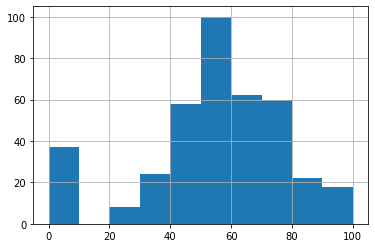

In [9]:
stud_math.score.hist()

Думаю, что нули - это аномалия, удалим их.

In [10]:
stud_math = stud_math.loc[stud_math.score > 0]

<AxesSubplot:>

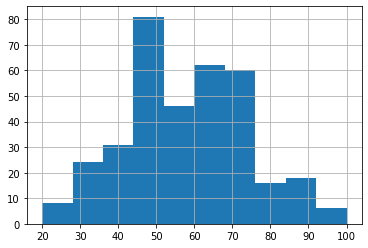

In [11]:
stud_math.score.hist()

Пойдём смотреть столбцы. Первый у нас - школа:

In [12]:
print(stud_math.school.value_counts())

GP    311
MS     41
Name: school, dtype: int64


Всего две школы, никаких битых или нулевых значений.

In [13]:
print(stud_math.sex.value_counts())

F    182
M    170
Name: sex, dtype: int64


С половой принадлежностью тоже все просто.

In [14]:
print(stud_math.age.value_counts())

16    96
17    90
15    76
18    69
19    16
20     3
21     1
22     1
Name: age, dtype: int64


... и с возрастом

In [15]:
print(stud_math.address.value_counts())

U    265
R     73
Name: address, dtype: int64


В этом столбце есть незаполненные ячейки, помечены как 'NaN'

Продолжаем рассматривать все колонки, в колонке fedu (образование отца) обнаруживается выброс:

In [16]:
print(stud_math.fedu.value_counts())

2.0     94
3.0     89
4.0     80
1.0     65
0.0      2
40.0     1
Name: fedu, dtype: int64


Убираем его сразу:

In [17]:
stud_math = delete_outliers(stud_math, 'fedu')

1 quantile = 2.0, median = 3.0, 3 quantile = 3.0, IQR = 1.0


В колонке famrel есть ошибка, убираем

In [18]:
print(stud_math.famrel.value_counts())

 4.0    150
 5.0     84
 3.0     53
 2.0     13
 1.0      6
-1.0      1
Name: famrel, dtype: int64


In [19]:
stud_math = stud_math.loc[stud_math.famrel > 0]

В столбце studytime_granular все значения со знаком минус. Убираем знак, потому что очевидно, что это свободное время в часах.

In [20]:
print(stud_math.studytime_granular.value_counts())

-6.0     151
-3.0      80
-9.0      47
-12.0     21
Name: studytime_granular, dtype: int64


In [21]:
stud_math.studytime_granular = -stud_math.studytime_granular

В столбце с пропусками занятий видны какие-то аномалии, посмотрим на него подробнее

In [22]:
print(stud_math.absences.value_counts())

0.0      64
2.0      53
4.0      46
6.0      26
8.0      19
10.0     14
12.0     11
14.0      9
16.0      7
3.0       7
7.0       5
18.0      4
5.0       4
22.0      3
20.0      3
15.0      2
9.0       2
1.0       2
40.0      1
38.0      1
56.0      1
23.0      1
24.0      1
25.0      1
385.0     1
11.0      1
13.0      1
17.0      1
21.0      1
212.0     1
28.0      1
26.0      1
54.0      1
Name: absences, dtype: int64


<AxesSubplot:>

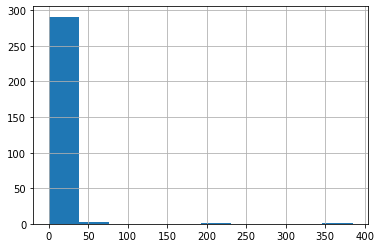

In [23]:
stud_math.absences.hist()

Чистим от выбросов:

In [24]:
stud_math = delete_outliers(stud_math, 'absences')

1 quantile = 2.0, median = 4.0, 3 quantile = 8.0, IQR = 6.0


<AxesSubplot:>

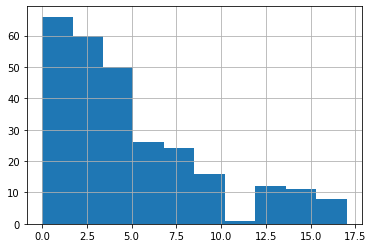

In [25]:
stud_math.absences.hist()

Посмотрим, что у нас осталось:

In [26]:
stud_math.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              274 non-null    object 
 1   sex                 274 non-null    object 
 2   age                 274 non-null    int64  
 3   address             264 non-null    object 
 4   famsize             259 non-null    object 
 5   pstatus             244 non-null    object 
 6   medu                272 non-null    float64
 7   fedu                274 non-null    float64
 8   mjob                260 non-null    object 
 9   fjob                250 non-null    object 
 10  reason              261 non-null    object 
 11  guardian            248 non-null    object 
 12  traveltime          254 non-null    float64
 13  studytime           269 non-null    float64
 14  failures            260 non-null    float64
 15  schoolsup           265 non-null    object 
 16  famsup  

Посмотрим на корреляции между числовыми колонками:

In [27]:
correlation = stud_math.corr()

<AxesSubplot:>

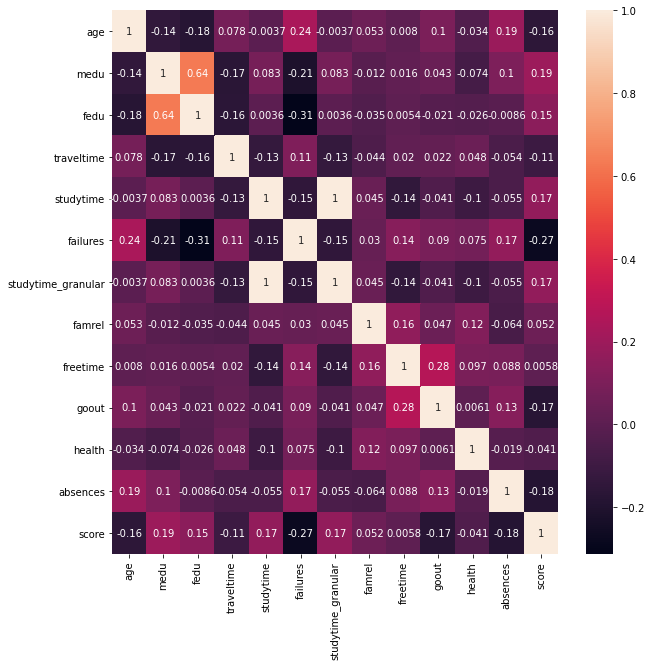

In [28]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(correlation, annot=True)

Ряд предварительных выводов:
1) образование отца и матери сильно коррелирует, что логично
2) возраст коррелирует с жизненными неудачами, тоже логично
3) количество свободного времени коррелирует с проведением времени с друзьями. Какую то из этих колонок я не готов отбросить.
4) чем больше времение на прогулки, тем меньше на учебу
5) Чем лучше отношения в семье, тем больше свободного времени, интересно
6) количество неудач в жизни коррелирует с пропусками занятий
7) чем выше образование родителей, тем меньше неудач в жизни

8) отбросим колонку studytime, у нас есть более подробная studytime_granular, корреляция между ними равна 1, что тоже предсказуемо.
дальше про колонку score:
9) сильнее всего влияют положительно: образование матери, образование отца и время, затраченное на учебу.
10) сильное отрицательное влияние оказывают: неудачи в жизни (самая сильная корреляция в принципе), время, потраченное на прогулки с друзьями (мне кажется странным), возраст, пропуски занятий, время на дорогу до школы.
11) слабо влияют столбцы famrel, freetime, health. Отбросим их.

In [29]:
stud_math.drop(['studytime', 'famrel', 'freetime', 'health'], inplace = True, axis = 1)

Дальше я захотел посмотреть, как образование родителей влияет на итоговую оценку, причём с учётом того, кто из родителей является опекуном. Интересное наблюдение: если опекун - мать, то оценки вроде бы выше. Проверим.

<AxesSubplot:xlabel='medu', ylabel='score'>

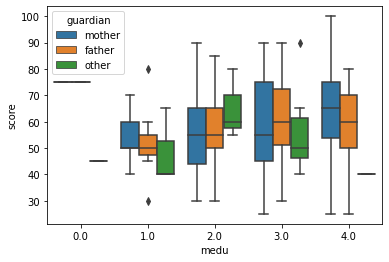

In [30]:
sns.boxplot(x="medu", y="score", data=stud_math, hue='guardian')

<AxesSubplot:xlabel='fedu', ylabel='score'>

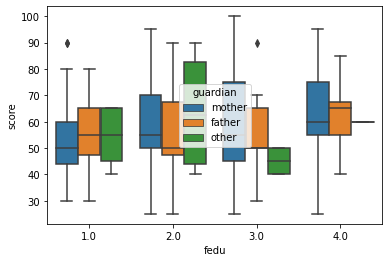

In [31]:
sns.boxplot(x="fedu", y="score", data=stud_math, hue='guardian')

Построим графики зависимости оценки от опекуна:

<AxesSubplot:xlabel='guardian', ylabel='score'>

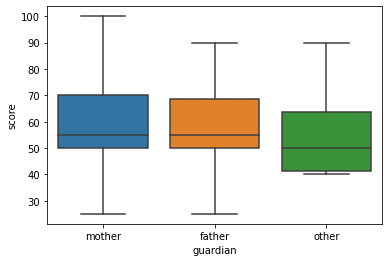

In [32]:
sns.boxplot(x="guardian", y="score", data=stud_math)

Чуть-чуть выше, но не сильно. Зато видим, что если опекун не один из родителей, то оценки ниже.

И построим графики зависимости оценки от строковых значений:

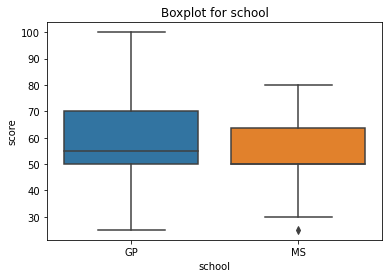

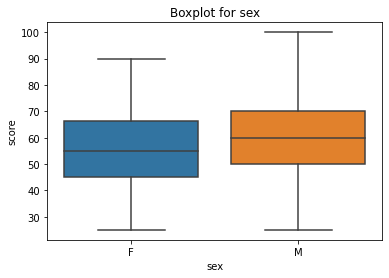

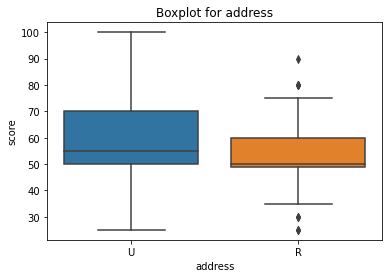

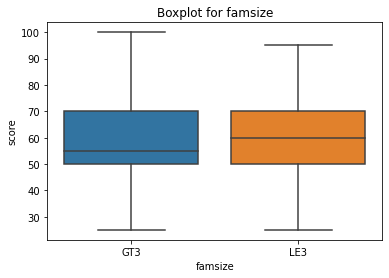

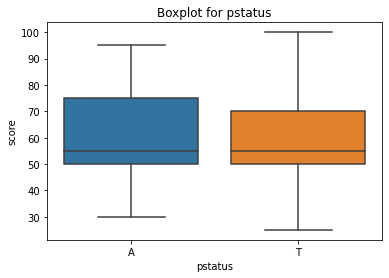

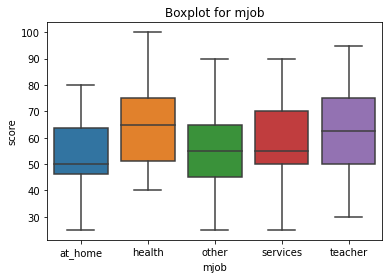

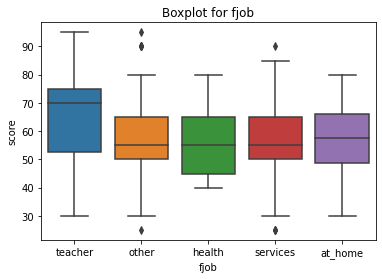

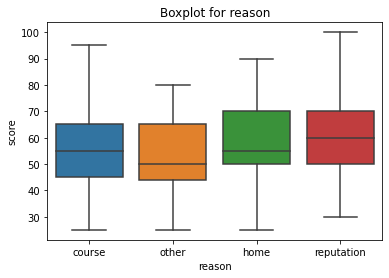

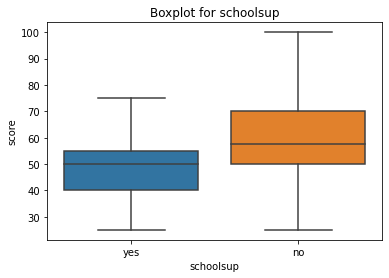

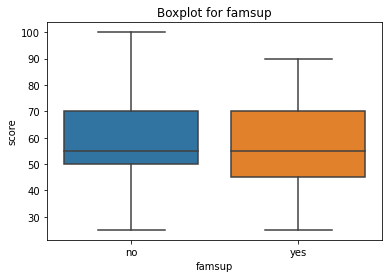

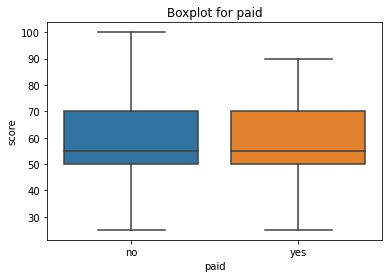

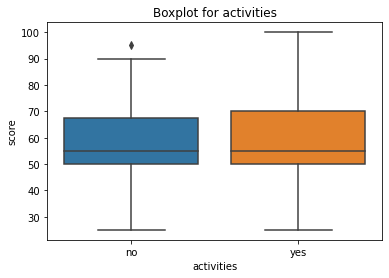

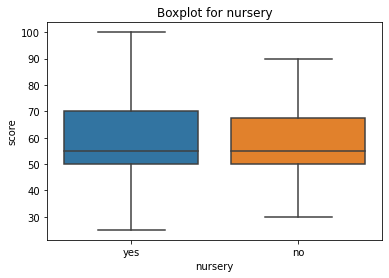

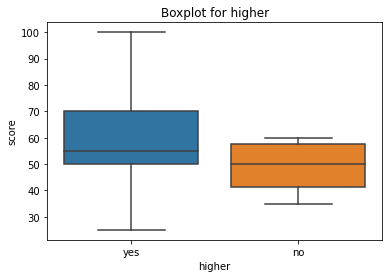

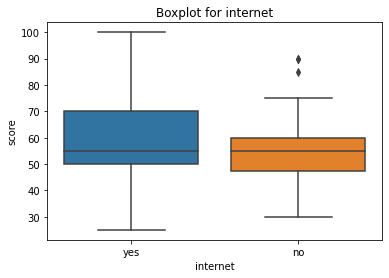

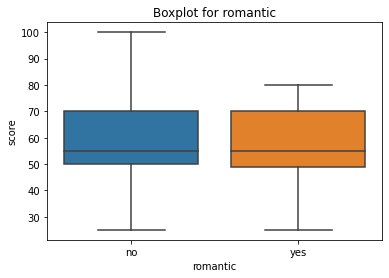

In [33]:
for col in ['school', 'sex', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_boxplot(stud_math, col, 'score')

Предварительные выводы:
1) сильно влияют на оценку: школа, пол, место жительства, работа родителей, доп поддержка в школе, прицел на высшее образование, наличие интернета.
2) можно отбросить дополнительные платные занятия, посещение детского сада, романтические отношения.

Проведём тест Стьюдента:

In [34]:
for col in ['school', 'sex', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(stud_math, col, 'score')

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки schoolsup


Видим, что существенно влияют на итоговую оценку колонки пол, место жительства, работа матери и дополнительная поддержка в школе.

Ещё интересно было бы посмотреть на корреляции между тремя или большим количеством столбцов.
Например, возможно, что в одной школе лучше учатся мальчики, в другой девочки, и это статистически значимо.
Или для детей, у которых опекун - мать, важнее её образование, и наоборот.
Попробуем руками проверить что-то из таких идей.

Итак, разные школы, разный пол:

<AxesSubplot:xlabel='school', ylabel='score'>

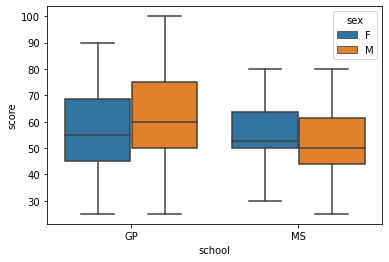

In [35]:
sns.boxplot(x="school", y="score", data=stud_math, hue='sex')

В GP мальчики как-будто бы учатся лучше! Проверим с помощью критерия Стьюдента:

In [36]:
get_stat_dif(stud_math.loc[stud_math.school == 'GP'], 'sex', 'score')

Найдены статистически значимые различия для колонки sex


In [37]:
get_stat_dif(stud_math.loc[stud_math.school == 'MS'], 'sex', 'score')

Действительно, пол имеет значение только в школе GP

Теперь проверим теорию с образованием родителей и опекуном:

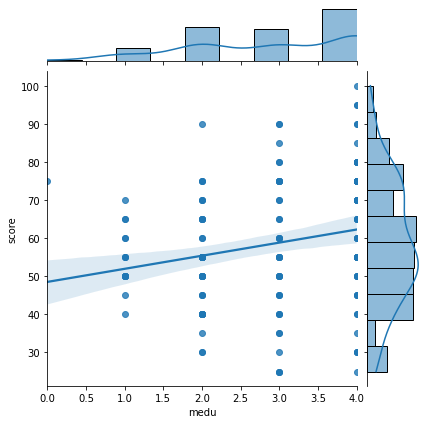

In [38]:
sns.jointplot(x="medu", y="score", data=stud_math.loc[stud_math.guardian == 'mother'], kind='reg')

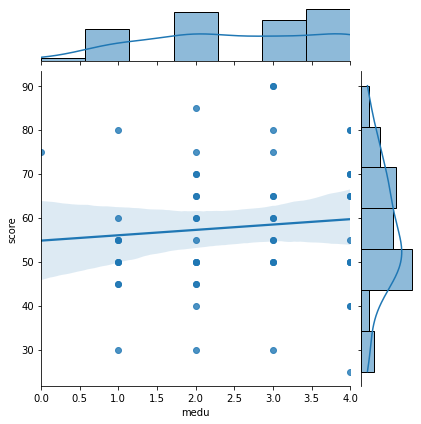

In [39]:
sns.jointplot(x="medu", y="score", data=stud_math.loc[stud_math.guardian == 'father'], kind='reg')

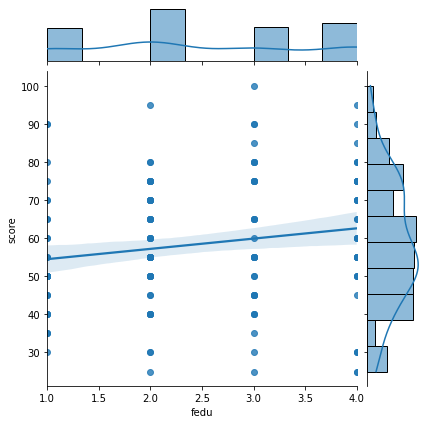

In [40]:
sns.jointplot(x="fedu", y="score", data=stud_math.loc[stud_math.guardian == 'mother'], kind='reg')

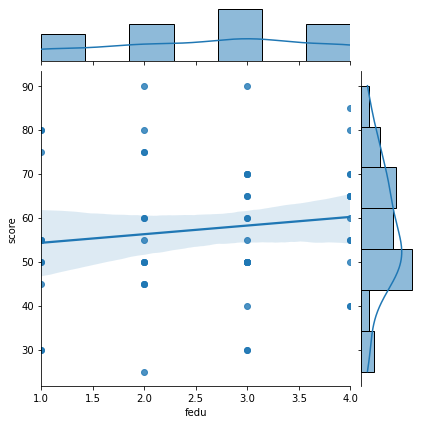

In [41]:
sns.jointplot(x="fedu", y="score", data=stud_math.loc[stud_math.guardian == 'father'], kind='reg')

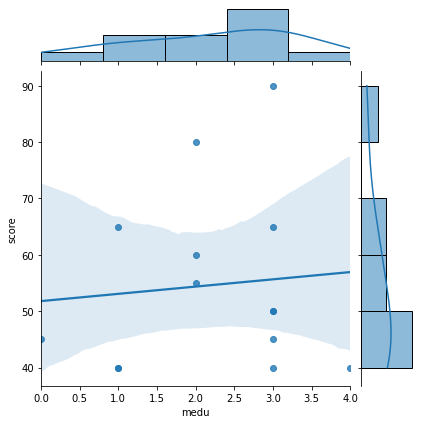

In [42]:
sns.jointplot(x="medu", y="score", data=stud_math.loc[stud_math.guardian == 'other'], kind='reg')

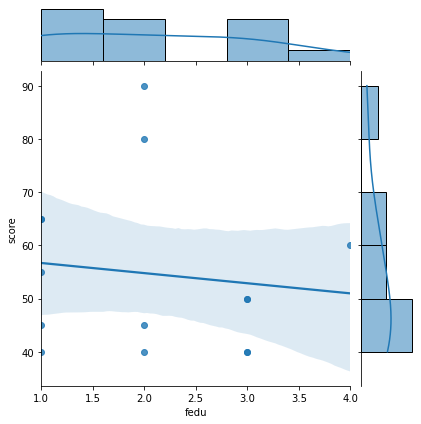

In [43]:
sns.jointplot(x="fedu", y="score", data=stud_math.loc[stud_math.guardian == 'other'], kind='reg')

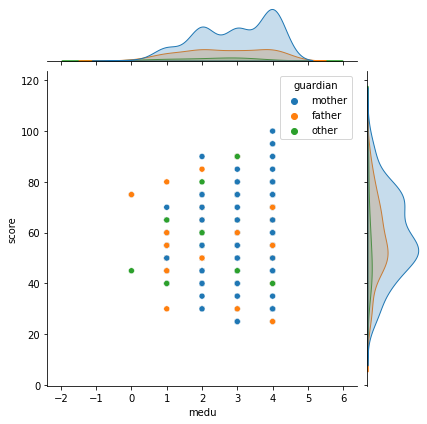

In [44]:
sns.jointplot(x="medu", y="score", data=stud_math, hue='guardian')

Вижу только, что с опекуном матерью дети в принципе получают более высокие оценки, больше выводов нет.

Итого, из текстовых колонок отбрасываем famsize, pstatus, fjob, reason, famsup, activities, higher, internet, paid, nursery, romantic

In [45]:
stud_math.drop(['famsize', 'pstatus', 'fjob', 'reason', 'famsup', 'activities', 'higher', 'internet', 'paid', 'nursery', 'romantic'], inplace = True, axis = 1)

Посмотрим что осталось:

In [46]:
stud_math.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274 entries, 0 to 394
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              274 non-null    object 
 1   sex                 274 non-null    object 
 2   age                 274 non-null    int64  
 3   address             264 non-null    object 
 4   medu                272 non-null    float64
 5   fedu                274 non-null    float64
 6   mjob                260 non-null    object 
 7   guardian            248 non-null    object 
 8   traveltime          254 non-null    float64
 9   failures            260 non-null    float64
 10  schoolsup           265 non-null    object 
 11  studytime_granular  269 non-null    float64
 12  goout               269 non-null    float64
 13  absences            274 non-null    float64
 14  score               274 non-null    float64
dtypes: float64(8), int64(1), object(6)
memory usage: 42.4+ KB

Подведём итоги

Признаки для построения модели:
    1) школа, в которой обучается ученик, в разных школах ученики разного пола показывают разные результаты.
    2) возраст ученика, положительно коррелирует с оценкой
    3) место жительства
    4) образование родителей
    5) работа матери 
    6) опекун (хоть этот столбец и не проходит по критерию Стьюдента, мне кажется, что он имеет некоторое значение)
    7) время в пути до школы
    8) жизненные неудачи
    9) дополнительная поддержка в школе
    10) время, потраченное на занятия
    11) время, потраченное на друзей
    12) пропуски занятий

В итоговом наборе данных у нас осталось 274 записи, почти все записи полные или почти полные. Выбросы в колонке score мы убрали полностью, в остальных колонках по необходимости.

На этом всё!